<div class="alert alert-block alert-success" !important>
    <h1 class="alert-heading">Assignment 08</h1>
In the previous assignment, we featurized the `retail-churn.csv` data using RFM. In this assignment, we build on the feature engineering we did in the last assignment and run k-means on the data with RFM features in order to do **customer segmentation**. Since k-means is unsupervised, we will also encounter challenges around interpreting results at the end.</div>

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from itertools import combinations, permutations
import seaborn as sns
%matplotlib inline

col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("../data/retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


<div class="alert alert-block alert-success"><h4 class="alert-heading">1. Rerun the feature engineering steps on the data to extract RFM features. <span style="color:red" float:right>[2 point]</span></h4></div>

In [2]:
# Create our dollar & quantity aggregrate columns
churn['timestamp'] = churn['timestamp'].astype('datetime64')
churn['date'] = churn['timestamp'].dt.date.astype('datetime64')
churn_agg = churn.groupby(['user_id', 'date']).agg({'quantity': sum, 'dollar':sum}).sort_values(by=['user_id', 'date'])

In [3]:
# Create our quantity and dollar 7 day rolling sum columns
churn_roll = churn_agg.reset_index().set_index('date').copy()
churn_roll = churn_roll.groupby('user_id')[['dollar', 'quantity']].rolling('7D').sum()
churn_roll.rename(columns={
    'quantity': 'quantity_roll_sum_7D',
    'dollar': 'dollar_roll_sum_7D'
}, inplace=True)
churn_roll['quantity_roll_sum_7D'] = churn_roll['quantity_roll_sum_7D'].astype('int')
churn_roll['dollar_roll_sum_7D'] = churn_roll['dollar_roll_sum_7D'].astype('int')

In [4]:
# Create our last_visit_ndays column
churn_roll.reset_index(inplace=True)
churn_roll['last_visit_ndays'] = churn_roll.groupby('user_id')['date'].diff()

In [5]:
# Fille NaT values with timedelta, reorder columns, and merge with aggregate data.
churn_roll.set_index(['user_id', 'date'], inplace=True)
churn_roll.fillna(value=pd.Timedelta('120 days'), inplace=True)
churn_roll = churn_roll.merge(churn_agg, left_index=True, right_index=True)
churn_roll

dollar_roll_sum_7D  quantity_roll_sum_7D last_visit_ndays  \
user_id date                                                                    
1113    2000-11-12                 420                     5         120 days   
        2000-11-26                 558                     3          14 days   
        2000-11-27                1182                     9           1 days   
        2001-01-06                 628                     9          40 days   
1250    2001-02-04                 734                     5         120 days   
...                                ...                   ...              ...   
2179315 2001-02-28                 377                     3         120 days   
2179346 2001-02-28                3567                    23         120 days   
2179414 2001-02-28                4993                    46         120 days   
2179469 2001-02-28                1706                    15         120 days   
2179605 2001-02-28                6001                    70         120 days   

                    quantity  dollar  
user_id date                          
1113    2000-11-12         5     420  
        2000-11-26         3     558  
        2000-11-27         6     624  
        2001-01-06         9     628  
1250    2001-02-04         5     734  
...                      ...     ...  
2179315 2001-02-28         3     377  
2179346 2001-02-28        23    3567  
2179414 2001-02-28        46    4993  
2179469 2001-02-28        15    1706  
2179605 2001-02-28        70    6001  

[37058 rows x 5 columns]

<div class="alert alert-block alert-success"><h4 class="alert-heading">2. Train a k-means algorithm on the RFM features using $k = 5$. What are the cluster centroids? The cluster centroids should be reported in the **original scale**, not the standardized scale. <span style="color:red" float:right>[2 point]</span> </h4></div>

<span style="color:maroon" float:right><em>The original question stated to use k = 5, I suspect this was a typo as the next question mentinoed that our original choice of k = 5 was arbitray.  As such the following is calculated with 5 clusters.  Simple enough to change to though</em></span>

<span style="color:maroon" float:right><em></em></span>
SPAN EM

In [6]:
# Original column names
columns_orig = ['last_visit_int', 'dollar_roll_sum_7D', 'quantity_roll_sum_7D']
# And column names for the standardized data
columns_norm = [col + "_norm" for col in columns_orig]

In [7]:
# Convert the timedelta from a datetime object into an integer value representing number of days.
churn_roll['last_visit_int'] = churn_roll['last_visit_ndays'].astype('int') / (1 * 10 ** 9) / 60 / 60 / 24

In [8]:
# churn_roll[[column + "_norm" for column in columns]] = (churn_roll[columns].values - churn_roll[columns].values.min(axis=0))  / (churn_roll[columns].values.max(axis=0) - churn_roll[columns].values.min(axis=0))
churn_roll[[column + "_norm" for column in columns_orig]] = (churn_roll[columns_orig].values - churn_roll[columns_orig].values.mean(axis=0))  / churn_roll[columns_orig].values.std(axis=0)
churn_roll[[column + "_norm" for column in columns_orig]].describe()

,last_visit_int_norm,dollar_roll_sum_7D_norm,quantity_roll_sum_7D_norm
count,3.705800e+04,3.705800e+04,3.705800e+04
mean,7.362740e-17,2.377551e-17,1.380514e-17
std,1.000013e+00,1.000013e+00,1.000013e+00
min,-8.818241e-01,-5.918738e-01,-5.530710e-01
25%,-7.997960e-01,-4.324457e-01,-4.157013e-01
50%,-5.537119e-01,-2.412283e-01,-1.867517e-01
75%,1.558510e+00,1.219403e-01,1.337778e-01
max,1.558510e+00,3.943133e+01,7.536662e+01


In [16]:
# df = churn_roll.copy()
# df.reset_index(inplace=True)
# df = df[columns_norm]

In [17]:
n_clusters = 5

In [20]:
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # Initialize
kmeans.fit(churn_roll[columns_norm])
churn_roll['cluster'] = kmeans.predict(churn_roll[columns_norm])
churn_roll.head(10)

dollar_roll_sum_7D  quantity_roll_sum_7D last_visit_ndays  \
user_id date                                                                    
1113    2000-11-12                 420                     5         120 days   
        2000-11-26                 558                     3          14 days   
        2000-11-27                1182                     9           1 days   
        2001-01-06                 628                     9          40 days   
1250    2001-02-04                 734                     5         120 days   
        2001-02-10                1583                    18           6 days   
1823    2000-11-02                1256                    16         120 days   
        2000-11-06                2174                    22           4 days   
        2001-01-24                 433                     3          79 days   
4947    2000-12-03                1875                    24         120 days   

                    quantity  dollar  last_visit_int  last_visit_int_norm  \
user_id date                                                                
1113    2000-11-12         5     420           120.0             1.558510   
        2000-11-26         3     558            14.0            -0.615233   
        2000-11-27         6     624             1.0            -0.881824   
        2001-01-06         9     628            40.0            -0.082051   
1250    2001-02-04         5     734           120.0             1.558510   
        2001-02-10        13     849             6.0            -0.779289   
1823    2000-11-02        16    1256           120.0             1.558510   
        2000-11-06         6     918             4.0            -0.820303   
        2001-01-24         3     433            79.0             0.717723   
4947    2000-12-03        24    1875           120.0             1.558510   

                    dollar_roll_sum_7D_norm  quantity_roll_sum_7D_norm  \
user_id date                                                             
1113    2000-11-12                -0.391987                  -0.369911   
        2000-11-26                -0.325518                  -0.461491   
        2000-11-27                -0.024965                  -0.186752   
        2001-01-06                -0.291802                  -0.186752   
1250    2001-02-04                -0.240747                  -0.369911   
        2001-02-10                 0.168179                   0.225358   
1823    2000-11-02                 0.010678                   0.133778   
        2000-11-06                 0.452838                   0.408517   
        2001-01-24                -0.385725                  -0.461491   
4947    2000-12-03                 0.308823                   0.500097   

                    cluster  
user_id date                 
1113    2000-11-12        2  
        2000-11-26        0  
        2000-11-27        0  
        2001-01-06        0  
1250    2001-02-04        2  
        2001-02-10        0  
1823    2000-11-02        2  
        2000-11-06        0  
        2001-01-24        2  
4947    2000-12-03        2

In [21]:
_std = churn_roll[columns_orig].values.std(axis=0)
_mean = churn_roll[columns_orig].values.mean(axis=0)

In [22]:
kmeans.inertia_

25307.75269272067

In [23]:
pairs_norm = list(combinations(columns_norm, 2))
pairs_orig = list(combinations(columns_orig, 2))

In [24]:
clusters_norm = pd.DataFrame(kmeans.cluster_centers_, columns=columns_norm)
clusters_norm

,last_visit_int_norm,dollar_roll_sum_7D_norm,quantity_roll_sum_7D_norm
0,-0.610449,-0.191783,-0.141015
1,-0.515772,1.566901,1.216691
2,1.494097,-0.147567,-0.135592
3,-0.828506,8.944625,43.945574
4,-0.683949,16.483978,7.001463


In [25]:
clusters_orig = clusters_norm * _std + _mean

In [26]:
clusters_orig.columns = clusters_orig.columns.str.replace("_norm", "")

In [27]:
custom_palette = sns.color_palette("Accent", 12)
custom_palette[1]

(0.7450980392156863, 0.6823529411764706, 0.8313725490196079)

In [28]:
def Plot2DKMeans(df, cf, pairs):
    fig, axs = plt.subplots(nrows = len(pairs), ncols = 1, figsize = (18, 24))
    for j, pair in enumerate(pairs):
        for i in range(cf.shape[0]):
            color = custom_palette[i]
            marker = ['s', 'o', 'v', '^', '<', '>', '8', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'][i]
#             sns.scatterplot(x = pair[0], y = pair[1], color=color, marker=marker, data = df.loc[df['cluster'] == i], ax = axs[j], legend = False)
            sns.scatterplot(x = pair[0], y = pair[1], color=color, marker=marker, data = df.loc[df['cluster'] == i], ax = axs[j], legend = False)
            sns.scatterplot(x = cf[pair[0]], y=cf[pair[1]], color='black', marker = 'X', ax = axs[j], s=200)
    plt.show()

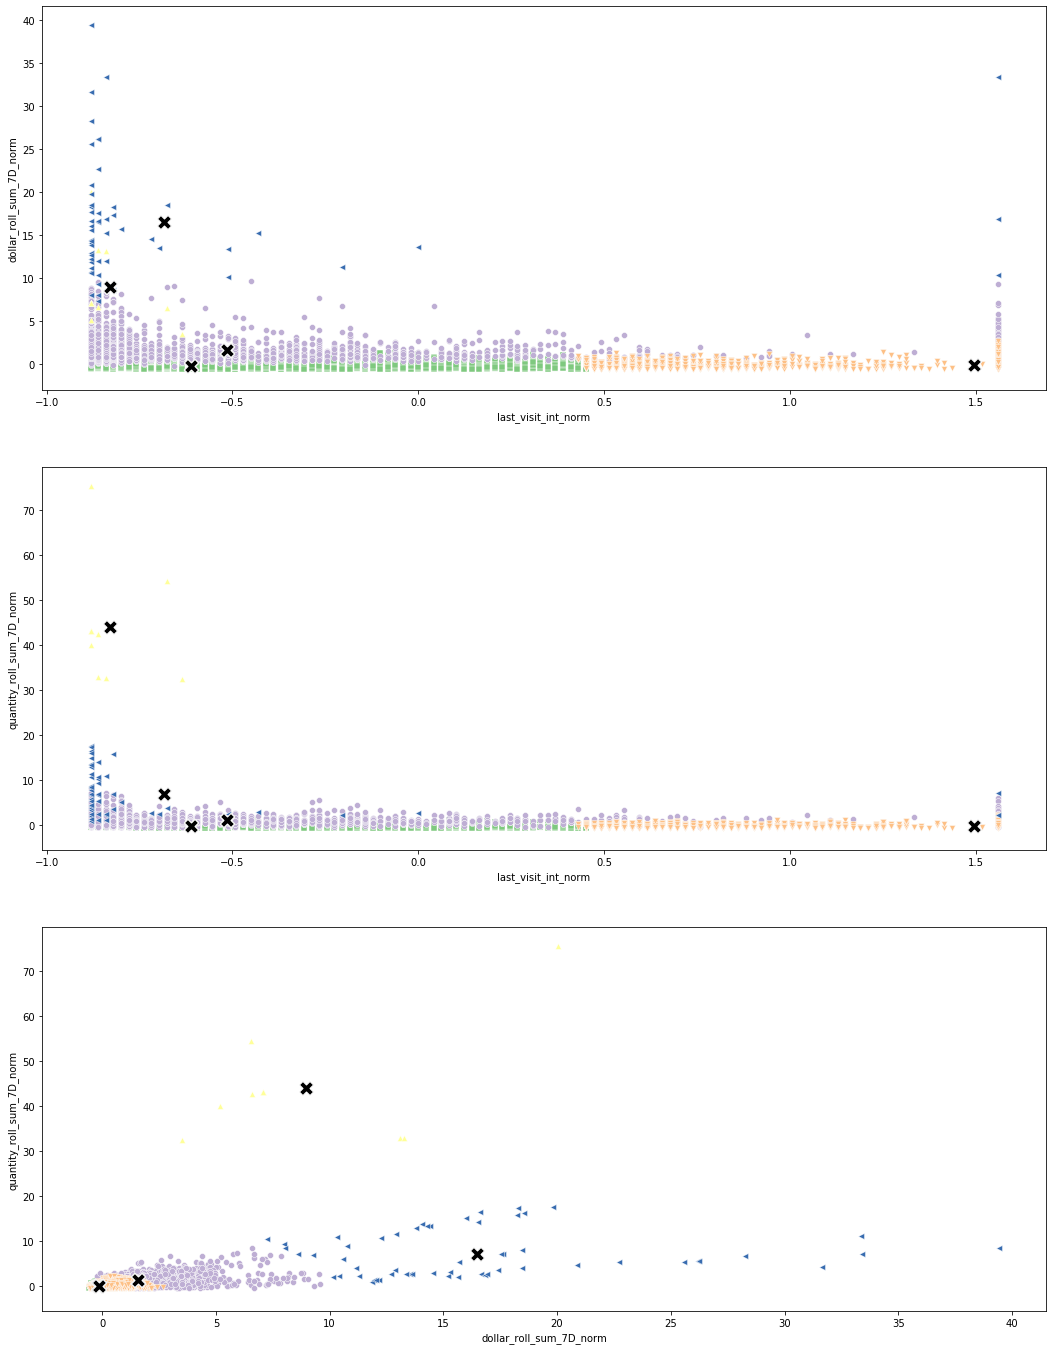

In [29]:
Plot2DKMeans(churn_roll, clusters_norm, pairs_norm)

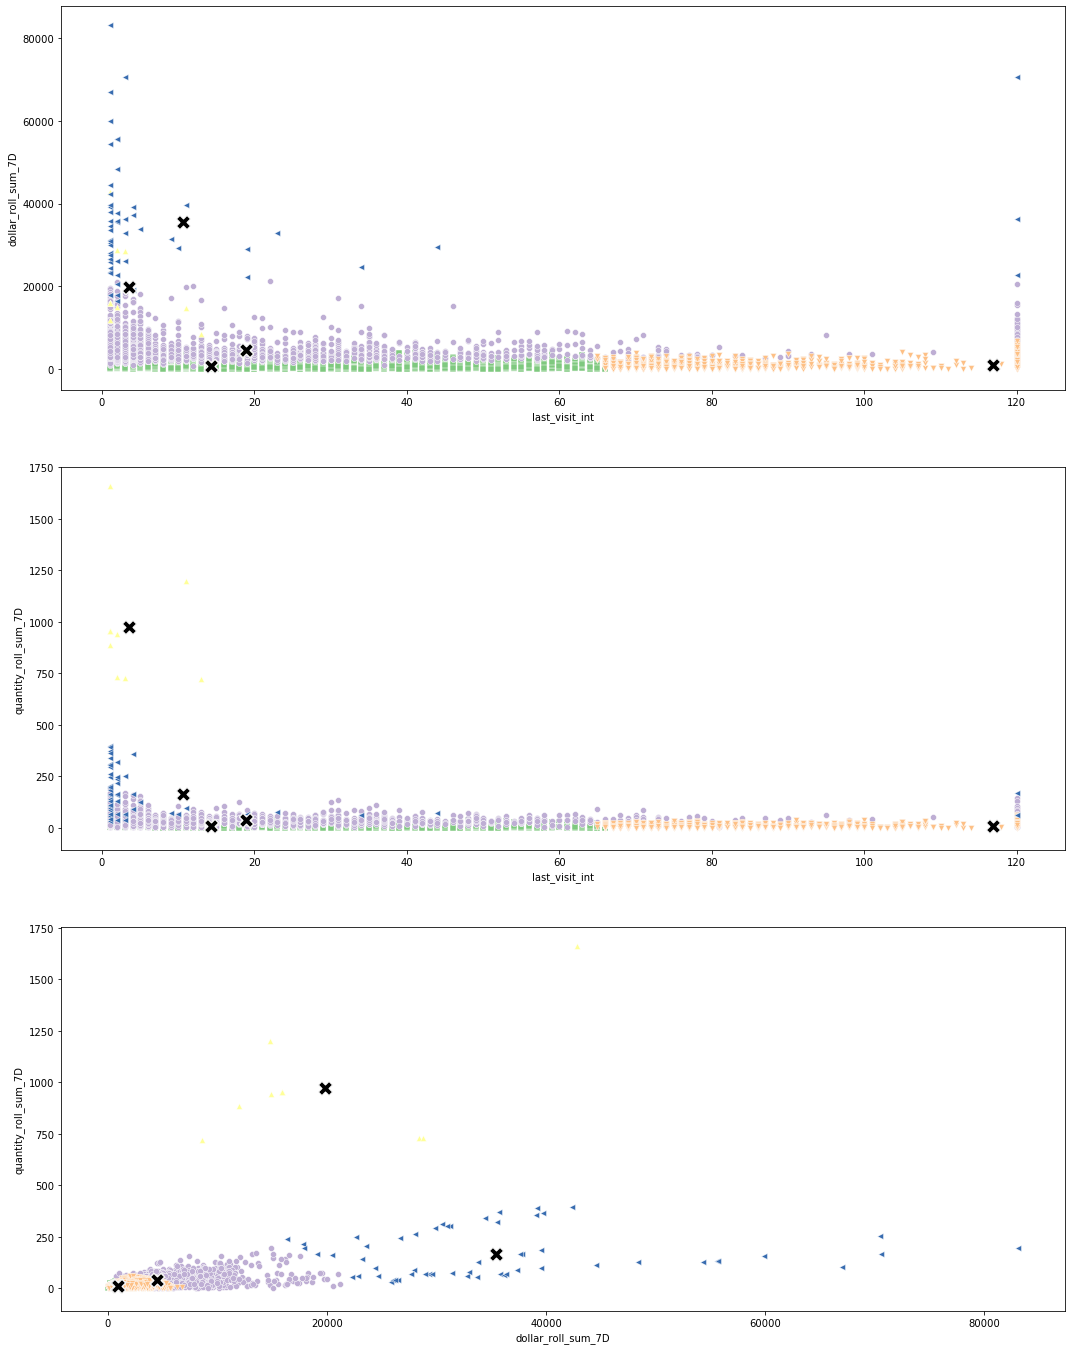

In [30]:
Plot2DKMeans(churn_roll, clusters_orig, pairs_orig)

<div class="alert alert-block alert-success"><h4 class="alert-heading">3. Our earlier choice of $k=5$ was arbitrary. To find a better number of $k$ create a **scree plot**, which plots the number of clusters $k$ on the x-axis and the sum of squared distances from each point to its cluster centroid on the y-axis. We can get the latter by calling the `inertia_` attribute as shown in the lab. Plot the scree plot for $k$ values from 3 to 15. <span style="color:red" float:right>[3 point]</span></hr></div>

In [31]:
sample_range = (3, 15)

In [32]:
def calculate_scree(sample_range, n_clusters, df):
    scree = []
    for k in range (sample_range[0], sample_range[1]):
        n_clusters = k
        kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
        kmeans.fit(df)
        scree.append((k, kmeans.inertia_))
    return scree

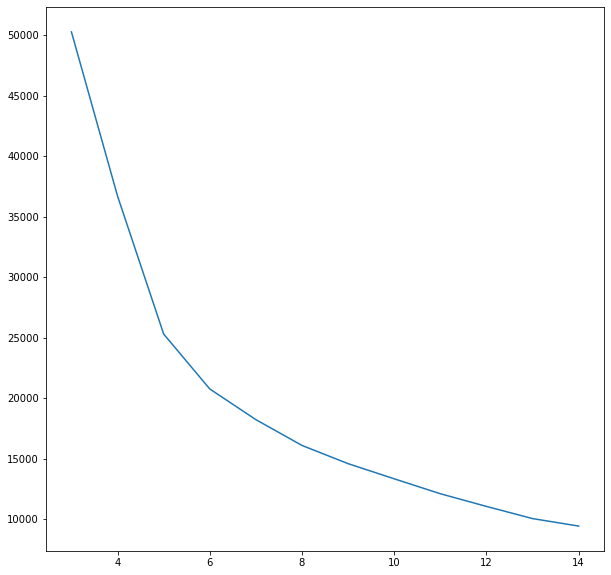

In [33]:
scree_array = np.array(calculate_scree(sample_range, n_clusters, churn_roll[columns_norm]))
fig, ax = plt.subplots(figsize=(10,10))
ax.ticklabel_format(style='plain')
ax.plot(range(sample_range[0], sample_range[1]), [x[1] for x in scree_array])
plt.show()

<div class="alert alert-block alert-success"><h4 class="alert-heading">4. Based on the scree plot, what is a good value to pick for $k$? Provide a brief justification for your choice. <span style="color:red" float:right>[2 point]</span></h4></div>

<span style="color:maroon" float:right><em>Tough choice, there's no distinct number at which it flattens our.  As such I'm going with 8, it isn't an overwhelming number of clusters to deal with and has, has just over half the inertia of 5, and diminishing returns</em></span>

<div class="alert alert-block alert-success"><h4 class="alert-heading">5. Train a k-means algorithm on the RFM features using your new value of $k$. Report the  size, mean and standard deviation for the RFM features for each cluster. <span style="color:red" float:right>[2 point]</span></h4></div>

In [34]:
n_clusters = 12
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # Initialize
kmeans.fit(churn_roll[columns_norm])
churn_roll['cluster'] = kmeans.predict(churn_roll[columns_norm])
churn_roll.head(10)

dollar_roll_sum_7D  quantity_roll_sum_7D last_visit_ndays  \
user_id date                                                                    
1113    2000-11-12                 420                     5         120 days   
        2000-11-26                 558                     3          14 days   
        2000-11-27                1182                     9           1 days   
        2001-01-06                 628                     9          40 days   
1250    2001-02-04                 734                     5         120 days   
        2001-02-10                1583                    18           6 days   
1823    2000-11-02                1256                    16         120 days   
        2000-11-06                2174                    22           4 days   
        2001-01-24                 433                     3          79 days   
4947    2000-12-03                1875                    24         120 days   

                    quantity  dollar  last_visit_int  last_visit_int_norm  \
user_id date                                                                
1113    2000-11-12         5     420           120.0             1.558510   
        2000-11-26         3     558            14.0            -0.615233   
        2000-11-27         6     624             1.0            -0.881824   
        2001-01-06         9     628            40.0            -0.082051   
1250    2001-02-04         5     734           120.0             1.558510   
        2001-02-10        13     849             6.0            -0.779289   
1823    2000-11-02        16    1256           120.0             1.558510   
        2000-11-06         6     918             4.0            -0.820303   
        2001-01-24         3     433            79.0             0.717723   
4947    2000-12-03        24    1875           120.0             1.558510   

                    dollar_roll_sum_7D_norm  quantity_roll_sum_7D_norm  \
user_id date                                                             
1113    2000-11-12                -0.391987                  -0.369911   
        2000-11-26                -0.325518                  -0.461491   
        2000-11-27                -0.024965                  -0.186752   
        2001-01-06                -0.291802                  -0.186752   
1250    2001-02-04                -0.240747                  -0.369911   
        2001-02-10                 0.168179                   0.225358   
1823    2000-11-02                 0.010678                   0.133778   
        2000-11-06                 0.452838                   0.408517   
        2001-01-24                -0.385725                  -0.461491   
4947    2000-12-03                 0.308823                   0.500097   

                    cluster  
user_id date                 
1113    2000-11-12        0  
        2000-11-26        6  
        2000-11-27        6  
        2001-01-06       10  
1250    2001-02-04        0  
        2001-02-10        1  
1823    2000-11-02        0  
        2000-11-06        1  
        2001-01-24       10  
4947    2000-12-03       11

In [35]:
clusters_standardized = pd.DataFrame(kmeans.cluster_centers_, columns=columns_norm)
clusters_standardized

,last_visit_int_norm,dollar_roll_sum_7D_norm,quantity_roll_sum_7D_norm
0,1.543368,-0.306819,-0.271867
1,-0.718166,0.174868,0.226273
2,-0.874500,15.430308,14.168388
3,-0.646533,8.801970,3.233032
4,-0.433116,3.023068,2.085473
5,-0.881824,20.038895,75.366617
6,-0.684473,-0.366217,-0.309477
7,-0.822582,7.711928,40.454347
8,-0.585612,23.756021,5.570059
9,-0.684429,1.073389,0.961601


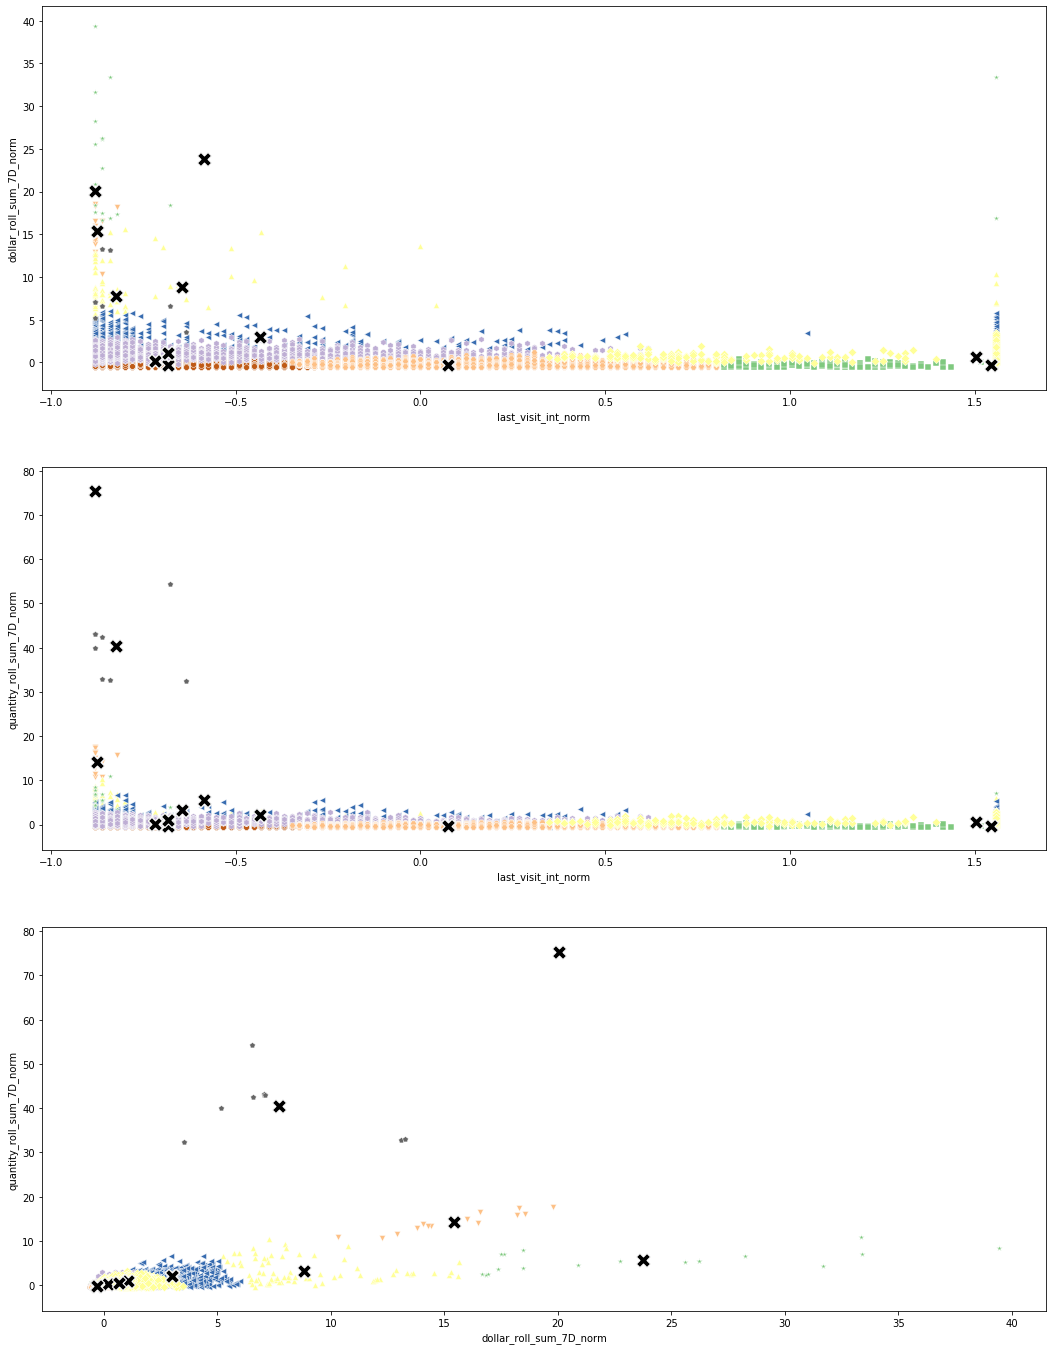

In [36]:
Plot2DKMeans(churn_roll, clusters_standardized, pairs_norm)

<div class="alert alert-block alert-success"><h4 class="alert-heading">6. Pick 3 clusters at random and describe what makes them different from one another (in terms of their RFM features). <span style="color:red" float:right>[3 point]</span></hr></div>

In [37]:
cluter_df = pd.DataFrame()

for i in range(n_clusters):
    print(f"cluster: {i} - 7D Dollar Mean: {churn_roll.loc[churn_roll['cluster'] == i]['dollar_roll_sum_7D'].mean()}")
for i in range(n_clusters):    
    print(f"cluster: {i} - 7D Quantity Mean: {churn_roll.loc[churn_roll['cluster'] == i]['quantity_roll_sum_7D'].mean()}")
for i in range(n_clusters):    
    print(f"cluster: {i} - Last Visit: {churn_roll.loc[churn_roll['cluster'] == i]['last_visit_ndays'].mean()}")
    

cluster: 0 - 7D Dollar Mean: 596.6679254476794
cluster: 1 - 7D Dollar Mean: 1590.2067830566687
cluster: 2 - 7D Dollar Mean: 33269.78571428572
cluster: 3 - 7D Dollar Mean: 19508.223684210527
cluster: 4 - 7D Dollar Mean: 7510.021015761821
cluster: 5 - 7D Dollar Mean: 42838.0
cluster: 6 - 7D Dollar Mean: 471.13911336001814
cluster: 7 - 7D Dollar Mean: 17245.11111111111
cluster: 8 - 7D Dollar Mean: 50555.38888888889
cluster: 9 - 7D Dollar Mean: 3451.974642126789
cluster: 10 - 7D Dollar Mean: 652.9855585027999
cluster: 11 - 7D Dollar Mean: 2615.493072145246
cluster: 0 - 7D Quantity Mean: 7.140455597514922
cluster: 1 - 7D Quantity Mean: 17.94977103606182
cluster: 2 - 7D Quantity Mean: 322.5
cluster: 3 - 7D Quantity Mean: 83.6842105263158
cluster: 4 - 7D Quantity Mean: 58.54290718038529
cluster: 5 - 7D Quantity Mean: 1659.0
cluster: 6 - 7D Quantity Mean: 6.292198474435466
cluster: 7 - 7D Quantity Mean: 896.5555555555555
cluster: 8 - 7D Quantity Mean: 134.72222222222223
cluster: 9 - 7D Quantit

In [38]:
churn_roll.loc[churn_roll['cluster'] == 1]

,,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays,quantity,dollar,last_visit_int,last_visit_int_norm,dollar_roll_sum_7D_norm,quantity_roll_sum_7D_norm,cluster
user_id,date,,,,,,,,,,
1250,2001-02-10,1583,18,6 days,13,849,6.0,-0.779289,0.168179,0.225358,1
1823,2000-11-06,2174,22,4 days,6,918,4.0,-0.820303,0.452838,0.408517,1
4947,2000-12-10,1488,16,7 days,16,1488,7.0,-0.758782,0.122422,0.133778,1
4978,2001-01-22,1194,13,19 days,13,1194,19.0,-0.512698,-0.019185,-0.003592,1
5241,2001-01-07,931,19,22 days,19,931,22.0,-0.451177,-0.145860,0.271148,1
...,...,...,...,...,...,...,...,...,...,...,...
2175447,2001-02-13,2176,19,5 days,3,189,5.0,-0.799796,0.453801,0.271148,1
2175522,2001-02-22,1698,29,14 days,29,1698,14.0,-0.615233,0.223570,0.729047,1
2176604,2001-02-25,2673,17,11 days,17,2673,11.0,-0.676754,0.693184,0.179568,1


In [39]:
churn_roll.loc[churn_roll['cluster'] == 3]

dollar_roll_sum_7D  quantity_roll_sum_7D last_visit_ndays  \
user_id date                                                                    
20459   2000-11-04               12108                   154           1 days   
        2000-11-05               13145                   169           1 days   
        2000-11-06               14899                   194           1 days   
        2000-11-09               13554                   172           3 days   
        2000-11-30               12498                   130           1 days   
...                                ...                   ...              ...   
2134819 2001-01-20               32947                    79          23 days   
2141282 2000-12-15               17052                    50          31 days   
        2000-12-17               17730                    52           2 days   
        2001-01-08               19699                    48          11 days   
        2001-01-20               20018                    48          12 days   

                    quantity  dollar  last_visit_int  last_visit_int_norm  \
user_id date                                                                
20459   2000-11-04        28    2327             1.0            -0.881824   
        2000-11-05        15    1037             1.0            -0.881824   
        2000-11-06        25    1754             1.0            -0.881824   
        2000-11-09        46    2904             3.0            -0.840810   
        2000-11-30        38    2801             1.0            -0.881824   
...                      ...     ...             ...                  ...   
2134819 2001-01-20        79   32947            23.0            -0.430670   
2141282 2000-12-15        50   17052            31.0            -0.266614   
        2000-12-17         2     678             2.0            -0.861317   
        2001-01-08        48   19699            11.0            -0.676754   
        2001-01-20        48   20018            12.0            -0.656247   

                    dollar_roll_sum_7D_norm  quantity_roll_sum_7D_norm  \
user_id date                                                             
20459   2000-11-04                 5.237608                   6.452787   
        2000-11-05                 5.737085                   7.139636   
        2000-11-06                 6.581910                   8.284384   
        2000-11-09                 5.934082                   7.277005   
        2000-11-30                 5.425454                   5.353829   
...                                     ...                        ...   
2134819 2001-01-20                15.274836                   3.018543   
2141282 2000-12-15                 7.618915                   1.690635   
        2000-12-17                 7.945478                   1.782215   
        2001-01-08                 8.893858                   1.599055   
        2001-01-20                 9.047506                   1.599055   

                    cluster  
user_id date                 
20459   2000-11-04        3  
        2000-11-05        3  
        2000-11-06        3  
        2000-11-09        3  
        2000-11-30        3  
...                     ...  
2134819 2001-01-20        3  
2141282 2000-12-15        3  
        2000-12-17        3  
        2001-01-08        3  
        2001-01-20        3  

[76 rows x 10 columns]

In [40]:
churn_roll.loc[churn_roll['cluster'] == 5]

,,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays,quantity,dollar,last_visit_int,last_visit_int_norm,dollar_roll_sum_7D_norm,quantity_roll_sum_7D_norm,cluster
user_id,date,,,,,,,,,,
1970777,2000-11-29,42838,1659,1 days,724,28198,1.0,-0.881824,20.038895,75.366617,5


<div class="alert alert-block alert-success" !important><h1 class="alert-heading">End of assignment</h1></div>

<span style="color:maroon" float:right><em>Seems like our data has two monetary values, and recency, but no frequency</em></span>

In [ ]:
frequency = churn_agg.groupby('user_id')['quantity'].count().to_frame()
frequency = frequency.rename(columns={'quantity': 'frequency'})
churn_roll = churn_roll.merge(frequency, how="left", left_index=True, right_index=True)